### Load rOMERO-gateway

In [3]:
library(romero.gateway)

Loading required package: rJava
Loading required package: jpeg
Warning message:
“replacing previous import ‘rJava::tail’ by ‘utils::tail’ when loading ‘romero.gateway’”Warning message:
“replacing previous import ‘rJava::str’ by ‘utils::str’ when loading ‘romero.gateway’”Warning message:
“replacing previous import ‘rJava::head’ by ‘utils::head’ when loading ‘romero.gateway’”
*** Welcome to rOMERO ***



### Connect to the server

In [4]:
server <- OMEROServer(host = 'eel.openmicroscopy.org', username='user-1', password='', port= as.integer(4064))
server <- connect(server)

### OMERO dataset and Annotation details

In [5]:
datasetName <- 'Cambridge'
fileName <- 'Cells.csv'
imageSize <- 199 # image size in um

### Find the dataset and get the attachment

In [6]:
searchResult <- searchFor(server, Dataset, 'Name', datasetName)
omeDataset <- searchResult[[1]]
print(omeDataset@dataobject$getId())

# Find the attached csv file
fileAnnotation <- getAnnotations(server, 'DatasetData', getOMEROID(omeDataset), nameFilter = fileName)
annotationFileID = as.integer(fileAnnotation$FileID)
print(annotationFileID)

[1] 21601
[1] 138674


### Load annotation as a R-Dataframe and compare cell areas between the two sets of images

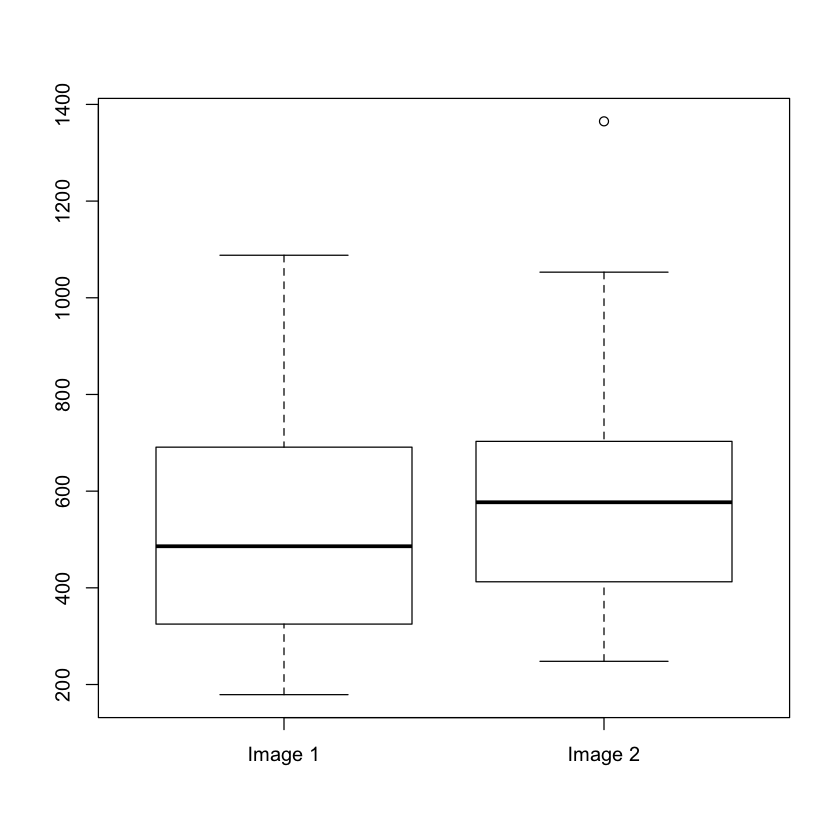

In [18]:
df <- loadCSV(server, annotationFileID)
dfLength <- subset(df, select=c("ImageNumber", "AreaShape_Area"))
boxplot(dfLength$AreaShape_Area~dfLength$ImageNumber, names=c("Image 1", "Image 2"))

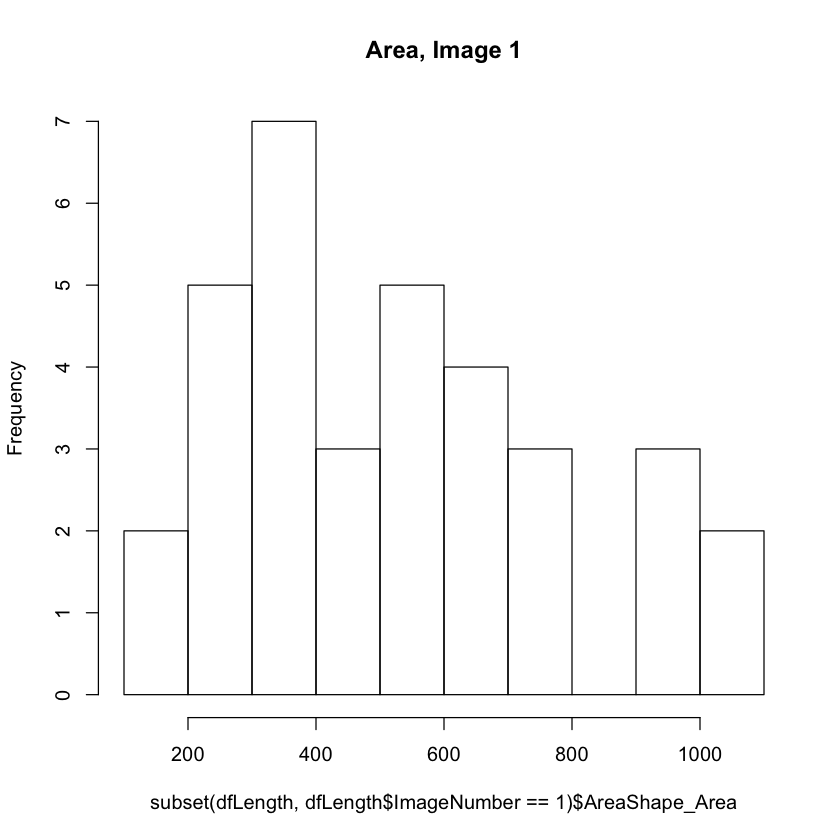

In [26]:
hist(subset(dfLength, dfLength$ImageNumber == 1)$AreaShape_Area, main = "Area, Image 1")

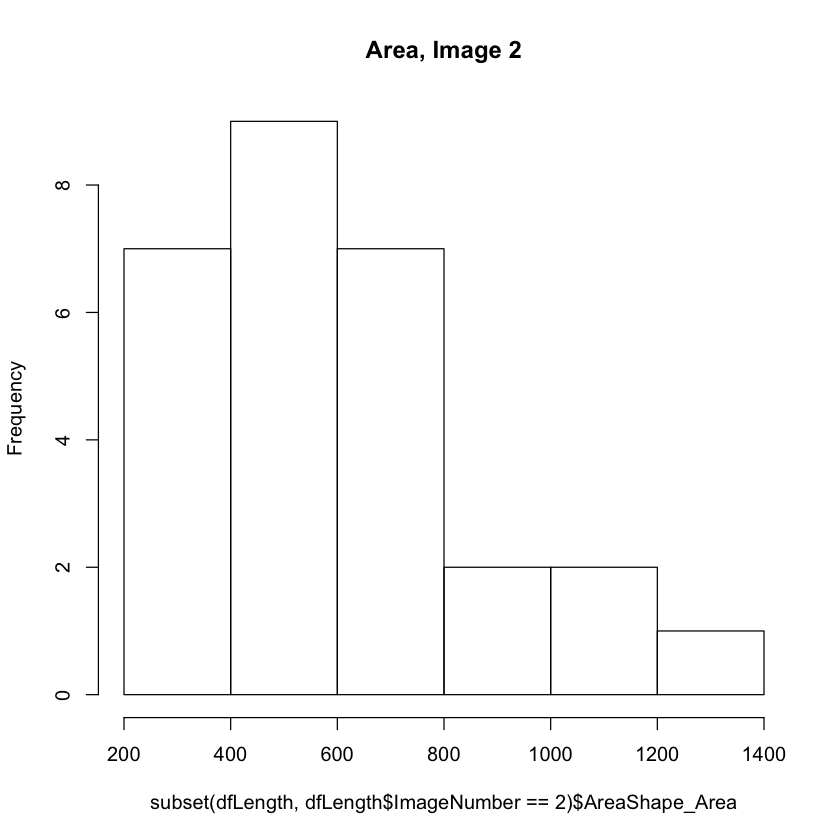

In [21]:
hist(subset(dfLength, dfLength$ImageNumber == 2)$AreaShape_Area, main = "Area, Image 2")

In [23]:
t.test(dfLength$AreaShape_Area~dfLength$ImageNumber)


	Welch Two Sample t-test

data:  dfLength$AreaShape_Area by dfLength$ImageNumber
t = -1.0616, df = 57.929, p-value = 0.2928
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -201.18223   61.74526
sample estimates:
mean in group 1 mean in group 2 
       531.8529        601.5714 


### Plot Centroids of the cells and check confluency using clustering methods

In [14]:
install.packages("spatstat")

also installing the dependencies ‘spatstat.data’, ‘spatstat.utils’, ‘deldir’, ‘abind’, ‘tensor’, ‘polyclip’, ‘goftest’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


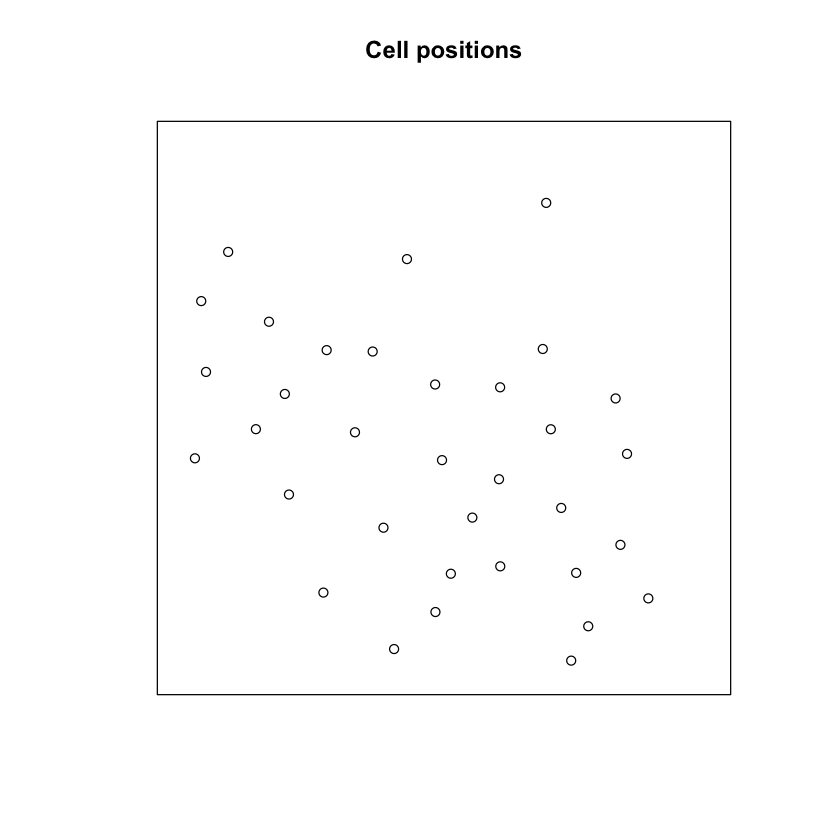

In [28]:
library(spatstat)
dfLocationImg1 <- subset(df, select=c("Location_Center_X", "Location_Center_Y"), df$ImageNumber == 1)
dfLocationImg1$Location_Center_Y <- imageSize - dfLocationImg1$Location_Center_Y
# Convert the cell positions into spatial format
points <- as.ppp(dfLocationImg1, c(1,imageSize,1,imageSize))
plot.ppp(points, main = "Cell positions")

### Save Plot back to OMERO

In [18]:
# Attach the plot to the dataset
tmpfile <- "/tmp/boxplot.png"
png(tmpfile)
plot.ppp(points, main = "Cell positions")
dev.off()
attachFile(omeDataset, tmpfile)

pdf 
  2

An object of class "OMERO"
Slot "server":
An object of class "OMEROServer"
Slot "host":
[1] "eel.openmicroscopy.org"

Slot "port":
[1] 4064

Slot "username":
[1] "user-1"

Slot "password":
[1] "ome"

Slot "credentialsFile":
character(0)

Slot "gateway":
[1] "Java-Object{omero.gateway.Gateway@60df60da}"

Slot "user":
[1] "Java-Object{omero.gateway.model.ExperimenterData (id=8)}"

Slot "ctx":
[1] "Java-Object{SecurityContext [groupID=9, experimenter=null, sudo=false, serverInformation=null, compression=0.85]}"


Slot "dataobject":
[1] "Java-Object{omero.gateway.model.FileAnnotationData (id=32607)}"


### Perform Hopkins test

Test for clustering ( H < 1) vs regularity (H > 1)

In [29]:
hopskel(points)
hopskel.test(points)

[1] 0.7004572


	Hopkins-Skellam test of CSR
	using F distribution

data:  points
A = 0.66323, p-value = 0.09276
alternative hypothesis: two-sided


### Attach the Hopkins test output to the dataset

In [20]:
tmpfile <- "/tmp/summary.txt"
sink(tmpfile)
hopskel.test(points)
sink()
attachFile(omeDataset, tmpfile)


	Hopkins-Skellam test of CSR
	using F distribution

data:  points
A = 1.1956, p-value = 0.4634
alternative hypothesis: two-sided


An object of class "OMERO"
Slot "server":
An object of class "OMEROServer"
Slot "host":
[1] "eel.openmicroscopy.org"

Slot "port":
[1] 4064

Slot "username":
[1] "user-1"

Slot "password":
[1] "ome"

Slot "credentialsFile":
character(0)

Slot "gateway":
[1] "Java-Object{omero.gateway.Gateway@60df60da}"

Slot "user":
[1] "Java-Object{omero.gateway.model.ExperimenterData (id=8)}"

Slot "ctx":
[1] "Java-Object{SecurityContext [groupID=9, experimenter=null, sudo=false, serverInformation=null, compression=0.85]}"


Slot "dataobject":
[1] "Java-Object{omero.gateway.model.FileAnnotationData (id=32608)}"


### Disconnect OMERO session

In [ ]:
disconnect(server)